In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CNN (Sequential)

In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Define data directories
train_dir = '/content/drive/MyDrive/RetinalImageClassification/Training_Set'
test_dir = '/content/drive/MyDrive/RetinalImageClassification/Test_Set'
eval_dir = '/content/drive/MyDrive/RetinalImageClassification/Evaluation_Set'

In [ ]:
#Create data generators with data augumentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
eval_datagen = ImageDataGenerator(rescale=1.0/255.0)

In [ ]:
# Load and preprocess data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Adjust target size as needed
    batch_size=32,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)
eval_data = eval_datagen.flow_from_directory(
    eval_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 557 images belonging to 1 classes.
Found 390 images belonging to 1 classes.
Found 479 images belonging to 1 classes.


In [ ]:
model = keras.Sequential([
    keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(64, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(128, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(256, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Conv2D(512, (3, 3), activation='relu'),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dropout(0.5),  # Adding dropout for regularization
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),  # Adding dropout for regularization
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(train_data, epochs=5, validation_data=eval_data)

Epoch 1/5
18/18 [==============================] - 227s 12s/step - loss: 0.0457 - accuracy: 0.9785 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
18/18 [==============================] - 214s 12s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
18/18 [==============================] - 215s 12s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
18/18 [==============================] - 202s 11s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
18/18 [==============================] - 213s 12s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


In [ ]:
val_loss, val_accuracy = model.evaluate(eval_data)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_accuracy)

15/15 [==============================] - 76s 5s/step - loss: 0.0000e+00 - accuracy: 1.0000
Validation Loss: 0.0
Validation Accuracy: 1.0


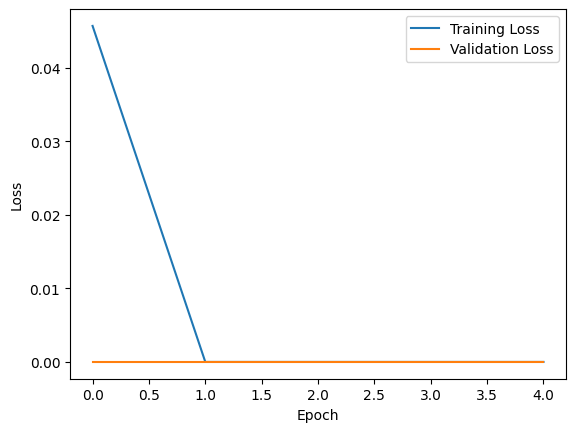

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


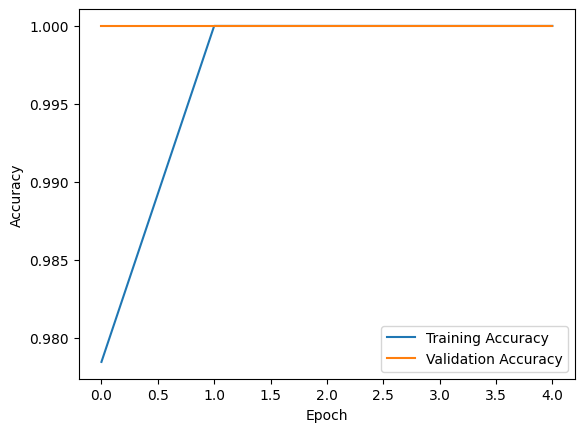

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


VGG19

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import numpy as np
import os

# Load the training CSV file containing image IDs and disease risk categories
csv_path_train = '/content/drive/MyDrive/RetinalImageClassification/Training_Set/RFMiD_Training_Labels.csv'
df_train = pd.read_csv(csv_path_train)

# Define the base directory for training images
base_dir_train = '/content/drive/MyDrive/RetinalImageClassification/Training_Set/Training'
image_paths_train = [os.path.join(base_dir_train, f"{img_id}.png") for img_id in df_train['ID'] if os.path.exists(os.path.join(base_dir_train, f"{img_id}.png"))]

# Load training images and labels
train_data = []
train_labels = df_train['Disease_Risk'].values

for image_path_train in image_paths_train:
    image_train = tf.keras.preprocessing.image.load_img(image_path_train, target_size=(224, 224))
    image_train = tf.keras.preprocessing.image.img_to_array(image_train)
    image_train = tf.keras.applications.vgg19.preprocess_input(image_train)
    train_data.append(image_train)

train_data = np.array(train_data)
train_labels = np.array(train_labels)

# Load the pre-trained VGG19 model
base_model_train = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model_train.layers:
    layer.trainable = False

# Add custom layers for classification
inputs_train = Input(shape=(224, 224, 3))
x_train = base_model_train(inputs_train, training=False)
x_train = Flatten()(x_train)
x_train = Dense(512, activation='relu')(x_train)
x_train = Dropout(0.5)(x_train)
outputs_train = Dense(1, activation='sigmoid')(x_train)  # Assuming binary classification (healthy vs. diseased)

# Create the training model
train_model = Model(inputs_train, outputs_train)

In [ ]:
# Compile the training model
train_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with print statements for each epoch
for epoch in range(10):
    print(f"Epoch {epoch + 1}/10")
    print("Training...")
    train_history = train_model.fit(train_data, train_labels, epochs=1, batch_size=32, validation_split=0.2, verbose=1)
    print(f"Training Accuracy: {train_history.history['accuracy'][-1]}")
    print(f"Validation Accuracy: {train_history.history['val_accuracy'][-1]}")
    print()

Epoch 1/10
Training...
14/14 [==============================] - 487s 36s/step - loss: 27.1435 - accuracy: 0.7438 - val_loss: 12.2137 - val_accuracy: 0.8571
Training Accuracy: 0.7438202500343323
Validation Accuracy: 0.8571428656578064

Epoch 2/10
Training...
14/14 [==============================] - 499s 36s/step - loss: 10.2303 - accuracy: 0.7753 - val_loss: 4.1651 - val_accuracy: 0.8393
Training Accuracy: 0.7752808928489685
Validation Accuracy: 0.8392857313156128

Epoch 3/10
Training...
14/14 [==============================] - 506s 37s/step - loss: 3.6478 - accuracy: 0.8067 - val_loss: 3.6552 - val_accuracy: 0.8571
Training Accuracy: 0.8067415952682495
Validation Accuracy: 0.8571428656578064

Epoch 4/10
Training...
14/14 [==============================] - 505s 37s/step - loss: 1.2501 - accuracy: 0.8270 - val_loss: 2.0248 - val_accuracy: 0.8571
Training Accuracy: 0.8269662857055664
Validation Accuracy: 0.8571428656578064

Epoch 5/10
Training...
14/14 [==============================] - 4

In [ ]:
import pandas as pd
import numpy as np
# Load the evaluation CSV file containing image IDs and disease risk categories
csv_path_eval = '/content/drive/MyDrive/RetinalImageClassification/Evaluation_Set/RFMiD_Validation_Labels.csv'
df_eval = pd.read_csv(csv_path_eval)

# Define the base directory for evaluation images
base_dir_eval = '/content/drive/MyDrive/RetinalImageClassification/Evaluation_Set/Validation'
image_paths_eval = [os.path.join(base_dir_eval, f"{img_id}.png") for img_id in df_eval['ID'] if os.path.exists(os.path.join(base_dir_eval, f"{img_id}.png"))]

# Load evaluation images and labels
eval_data = []
eval_labels = df_eval['Disease_Risk'].values

for image_path_eval in image_paths_eval:
    image_eval = tf.keras.preprocessing.image.load_img(image_path_eval, target_size=(224, 224))
    image_eval = tf.keras.preprocessing.image.img_to_array(image_eval)
    image_eval = tf.keras.applications.vgg19.preprocess_input(image_eval)
    eval_data.append(image_eval)

eval_data = np.array(eval_data)
eval_labels = np.array(eval_labels)
eval_data = eval_data[:min(len(eval_data), len(eval_labels))]
eval_labels = eval_labels[:min(len(eval_data), len(eval_labels))]

# Evaluate the model on the evaluation data
eval_loss, eval_accuracy = train_model.evaluate(eval_data, eval_labels, verbose=0)
print(f"Evaluation Loss: {eval_loss}")
print(f"Evaluation Accuracy: {eval_accuracy}")


Evaluation Loss: 1.1494877338409424
Evaluation Accuracy: 0.8016701340675354


ResNet50

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image  # For loading images
import os  # For file path operations
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import L2,L1,L1L2
from tensorflow.keras import models, layers, optimizers

In [ ]:
#training
image_size = (224, 224)
images_array = []
base_dir_train = '/content/drive/MyDrive/RetinalImageClassification/Training_Set/Training'
for filename in os.listdir(base_dir_train):
    img_path = os.path.join(base_dir_train, filename)
    img = Image.open(img_path)
    img = img.convert('RGB')
    img = img.resize(image_size)  # Resize to consistent size
    img_array = np.array(img)  # Convert to NumPy array
    images_array.append(img_array)

images_array = np.array(images_array)  # Final array creation

In [ ]:
images_array2 = []
base_dir_test = '/content/drive/MyDrive/RetinalImageClassification/Test_Set/Test'
for filename in os.listdir(base_dir_test):
    img_path = os.path.join(base_dir_test, filename)
    img = Image.open(img_path)
    img = img.convert('RGB')
    img = img.resize(image_size)  # Resize to consistent size
    img_array_ts = np.array(img)  # Convert to NumPy array
    images_array2.append(img_array_ts)

images_array2 = np.array(images_array2)  # Final array creation

In [ ]:
images_resized = [Image.fromarray(img).resize(image_size) for img in images_array]

# Convert the list of images to a NumPy array
images_resized_array = np.array([np.array(img) for img in images_resized])

In [ ]:
images_resized_ts = [Image.fromarray(img).resize(image_size) for img in images_array2]

# Convert the list of images to a NumPy array
images_resized_array_ts = np.array([np.array(img) for img in images_resized_ts])

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
train_ds = preprocess_input(images_resized_array)
test_ds = preprocess_input(images_resized_array_ts)

In [ ]:
csv_path_train = '/content/drive/MyDrive/RetinalImageClassification/Training_Set/RFMiD_Training_Labels.csv'
csv_path_test = '/content/drive/MyDrive/RetinalImageClassification/Test_Set/RFMiD_Testing_Labels.csv'

In [ ]:
csv_path_train = pd.read_csv('/content/drive/MyDrive/RetinalImageClassification/Training_Set/RFMiD_Training_Labels.csv')
new_df = csv_path_train[['Disease_Risk', 'DR', 'ARMD']]
num_classes = new_df.nunique()

In [ ]:
print("Number of classes:",num_classes )

Number of classes: Disease_Risk    2
DR              2
ARMD            2
dtype: int64


In [ ]:
csv_path_test = pd.read_csv('/content/drive/MyDrive/RetinalImageClassification/Test_Set/RFMiD_Testing_Labels.csv')
num_classes_ts = csv_path_test['Disease_Risk'].nunique()
print("Number of classes:", num_classes_ts)
num_classes_ts = csv_path_test.nunique()

Number of classes: 2


In [ ]:
# Assuming 'new_df' contains the labels
labels_multi = new_df[['Disease_Risk', 'DR', 'ARMD']]

# Convert to one-hot encoding
labels_one_hot_multi = labels_multi  # No need for to_categorical, as the labels are already binary

# ...

# Determine the minimum number of samples
min_samples = min(len(images_resized_array), len(labels_one_hot_multi))

# Truncate the arrays to the minimum number of samples
images_resized_array_truncated = images_resized_array[:min_samples]
labels_one_hot_multi_truncated = labels_one_hot_multi[:min_samples]

# Split the truncated data into training and validation sets
train_ds, val_ds, train_labels, val_labels = train_test_split(
    images_resized_array_truncated, labels_one_hot_multi_truncated, test_size=0.2, random_state=42, shuffle=True
)

# ...

# Creating the model
model = models.Sequential([
    base_model,
   layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=L2(0.001)),
    layers.Dropout(0.7),
    layers.Dense(64, activation='relu', kernel_regularizer=L2(0.001)),
    layers.Dropout(0.7),
    layers.Dense(3, activation='sigmoid')  # Output layer with 3 neurons for multi-class classification
])

# ...

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# ...

# Train the model
history = model.fit(
    train_ds, train_labels,
    epochs=10,
    validation_data=(val_ds, val_labels),
    batch_size=32,
)

Epoch 1/10
14/14 [==============================] - 362s 24s/step - loss: 4.0414 - accuracy: 0.6449 - val_loss: 677.4754 - val_accuracy: 1.0000
Epoch 2/10
14/14 [==============================] - 351s 25s/step - loss: 1.0788 - accuracy: 0.9348 - val_loss: 1825.1116 - val_accuracy: 1.0000
Epoch 3/10
14/14 [==============================] - 326s 23s/step - loss: 1.0921 - accuracy: 0.9798 - val_loss: 59.1527 - val_accuracy: 1.0000
Epoch 4/10
14/14 [==============================] - 341s 24s/step - loss: 1.0557 - accuracy: 1.0000 - val_loss: 7.0782 - val_accuracy: 1.0000
Epoch 5/10
14/14 [==============================] - 347s 25s/step - loss: 1.0223 - accuracy: 1.0000 - val_loss: 1.3924 - val_accuracy: 1.0000
Epoch 6/10
14/14 [==============================] - 322s 23s/step - loss: 0.9902 - accuracy: 1.0000 - val_loss: 0.9442 - val_accuracy: 1.0000
Epoch 7/10
14/14 [==============================] - 321s 23s/step - loss: 0.9594 - accuracy: 1.0000 - val_loss: 0.9431 - val_accuracy: 1.0000


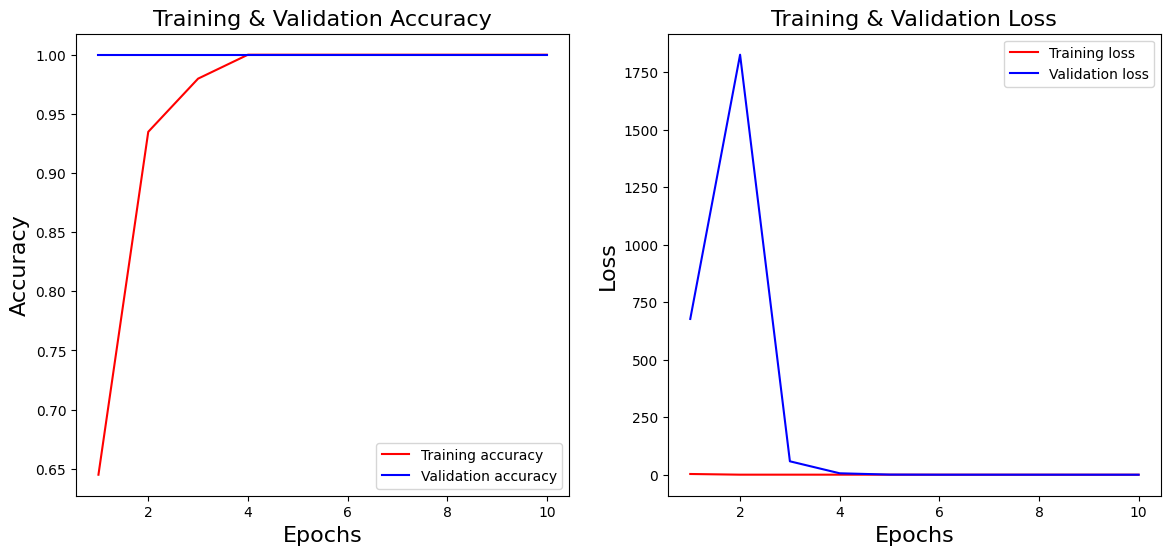

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))


# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()


# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend();

EfficientNetB0

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                    rotation_range = 30,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    zoom_range = 0.1,
                                    horizontal_flip = True
                                   )
train_generator = train_datagen.flow_from_directory('/content/drive/MyDrive/RetinalImageClassification/Training_Set',
                                                    target_size=(150,150),
                                                    class_mode='binary')

Found 557 images belonging to 1 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1/255)
validation_generator = validation_datagen.flow_from_directory('/content/drive/MyDrive/RetinalImageClassification/Evaluation_Set',
                                                              target_size=(150,150),
                                                              class_mode='binary')

Found 479 images belonging to 1 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory('/content/drive/MyDrive/RetinalImageClassification/Test_Set',
                                                              target_size=(150,150),
                                                              class_mode='binary')

Found 390 images belonging to 1 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow import keras

In [ ]:
model = EfficientNetB0(input_shape=(150,150,3), weights='imagenet', include_top=False)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
for layer in model.layers:
    layer.trainable = False

In [ ]:
x = model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(1, activation="sigmoid")(x)
m = Model(inputs=model.input, outputs=predictions)

In [ ]:
m.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])
history = m.fit(train_generator,epochs=10,
                              steps_per_epoch=10,
                              validation_data=validation_generator,
                             validation_steps=5)

Epoch 1/10
10/10 [==============================] - 155s 16s/step - loss: 0.1175 - accuracy: 0.9203 - val_loss: 8.7876e-21 - val_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 121s 13s/step - loss: 5.5184e-19 - accuracy: 1.0000 - val_loss: 8.7866e-21 - val_accuracy: 1.0000
Epoch 3/10
10/10 [==============================] - 120s 13s/step - loss: 1.4062e-18 - accuracy: 1.0000 - val_loss: 8.7815e-21 - val_accuracy: 1.0000
Epoch 4/10
10/10 [==============================] - 85s 9s/step - loss: 2.7826e-18 - accuracy: 1.0000 - val_loss: 8.7852e-21 - val_accuracy: 1.0000
Epoch 5/10
10/10 [==============================] - 77s 8s/step - loss: 2.3032e-18 - accuracy: 1.0000 - val_loss: 8.7854e-21 - val_accuracy: 1.0000
Epoch 6/10
10/10 [==============================] - 81s 8s/step - loss: 5.7173e-19 - accuracy: 1.0000 - val_loss: 8.7914e-21 - val_accuracy: 1.0000
Epoch 7/10
10/10 [==============================] - 67s 7s/step - loss: 1.6534e-18 - accuracy: 1.0000 - val_lo

In [ ]:
m.evaluate(test_generator)

13/13 [==============================] - 60s 5s/step - loss: 8.7731e-21 - accuracy: 1.0000


[8.77310181054442e-21, 1.0]

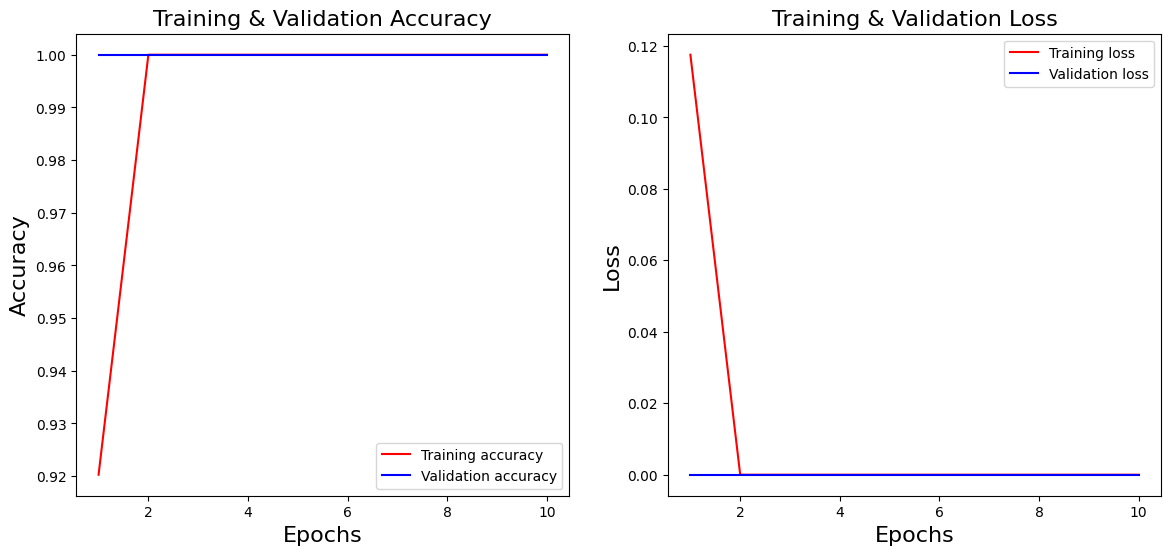

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))


# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()


# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend();

InceptionV3

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from keras.preprocessing import image
pd.options.display.max_columns = 50

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/RetinalImageClassification/Training_Set/RFMiD_Training_Labels.csv')
train_df

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,ODPM,PRH,MNF,HR,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
val_df = pd.read_csv('/content/drive/MyDrive/RetinalImageClassification/Evaluation_Set/RFMiD_Validation_Labels.csv')
val_df

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,ODPM,PRH,MNF,HR,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,636,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
636,637,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
637,638,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
638,639,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/RetinalImageClassification/Test_Set/RFMiD_Testing_Labels.csv')
test_df

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,ODPM,PRH,MNF,HR,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,636,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
636,637,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
637,638,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
638,639,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train_df['img_path'] = [f'/content/drive/MyDrive/RetinalImageClassification/Training_Set/Training/{id}.png' for id in train_df['ID']]

In [ ]:
train_df.head(3)

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,ODPM,PRH,MNF,HR,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL,img_path
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
2,3,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...


In [ ]:
val_df['img_path'] = [f'/content/drive/MyDrive/RetinalImageClassification/Evaluation_Set/Validation/{id}.png' for id in val_df['ID']]
val_df

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,ODPM,PRH,MNF,HR,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL,img_path
0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
1,2,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
2,3,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
3,4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
4,5,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,636,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
636,637,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
637,638,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
638,639,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...


In [ ]:
test_df['img_path'] = [f'/content/drive/MyDrive/RetinalImageClassification/Test_Set/Test/{id}.png' for id in test_df['ID']]
test_df

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,ODPM,PRH,MNF,HR,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL,img_path
0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
1,2,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
2,3,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
3,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
4,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,636,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
636,637,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
637,638,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
638,639,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...


In [ ]:
train_df = train_df.drop(labels=['ID'],axis=1)

In [ ]:
columns = list(train_df.columns)
columns.remove('img_path')
d_total = 0
for col in columns:
    print(col)
    print(train_df[col].value_counts())
    print('----------------')
    if col != 'Disease_Risk':
        d_total += train_df[col].sum()

print(d_total)

Disease_Risk
Disease_Risk
1    1519
0     401
Name: count, dtype: int64
----------------
DR
DR
0    1544
1     376
Name: count, dtype: int64
----------------
ARMD
ARMD
0    1820
1     100
Name: count, dtype: int64
----------------
MH
MH
0    1603
1     317
Name: count, dtype: int64
----------------
DN
DN
0    1782
1     138
Name: count, dtype: int64
----------------
MYA
MYA
0    1819
1     101
Name: count, dtype: int64
----------------
BRVO
BRVO
0    1847
1      73
Name: count, dtype: int64
----------------
TSLN
TSLN
0    1734
1     186
Name: count, dtype: int64
----------------
ERM
ERM
0    1906
1      14
Name: count, dtype: int64
----------------
LS
LS
0    1873
1      47
Name: count, dtype: int64
----------------
MS
MS
0    1905
1      15
Name: count, dtype: int64
----------------
CSR
CSR
0    1883
1      37
Name: count, dtype: int64
----------------
ODC
ODC
0    1638
1     282
Name: count, dtype: int64
----------------
CRVO
CRVO
0    1892
1      28
Name: count, dtype: int64
-------

In [ ]:
train_df = train_df.drop(labels=['Disease_Risk','ODPM', 'HR'], axis=1)
val_df = val_df.drop(labels=['ID', 'Disease_Risk', 'ODPM', 'HR'], axis=1)
test_df = test_df.drop(labels=['ID', 'Disease_Risk', 'ODPM', 'HR'], axis=1)

In [ ]:
train_df.columns

Index(['DR', 'ARMD', 'MH', 'DN', 'MYA', 'BRVO', 'TSLN', 'ERM', 'LS', 'MS',
       'CSR', 'ODC', 'CRVO', 'TV', 'AH', 'ODP', 'ODE', 'ST', 'AION', 'PT',
       'RT', 'RS', 'CRS', 'EDN', 'RPEC', 'MHL', 'RP', 'CWS', 'CB', 'PRH',
       'MNF', 'CRAO', 'TD', 'CME', 'PTCR', 'CF', 'VH', 'MCA', 'VS', 'BRAO',
       'PLQ', 'HPED', 'CL', 'img_path'],
      dtype='object')

In [ ]:
train_df[train_df['PTCR']==1]

,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,LS,MS,CSR,ODC,CRVO,TV,AH,ODP,ODE,ST,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,CWS,CB,PRH,MNF,CRAO,TD,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL,img_path
482,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
542,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
637,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
942,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...
982,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,/content/drive/MyDrive/RetinalImageClassificat...


In [ ]:
def weight_calc(col):
    total = len(train_df)
    weight = (1 / train_df[col].sum()) *  total / 2
    return weight

In [ ]:
Y_train = list(train_df.drop(['img_path'], axis=1).columns)
Y_val = list(val_df.drop(['img_path'], axis=1).columns)
Y_test = list(test_df.drop(['img_path'], axis=1).columns)
unq_disease = len(Y_train)

In [ ]:
class_weights = {}
for i in range(0, unq_disease):
    class_weights[f'{i}'] = weight_calc(Y_train[i])

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rotation_range=90,
                                                                brightness_range=[0, 0.1])
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(train_df,
                                              x_col='img_path',
                                              y_col=Y_train,
                                              target_size=(150,150),
                                              class_mode='raw',
                                              batch_size=16,
                                              shuffle=True)

Found 557 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1363 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
val_gen = val_datagen.flow_from_dataframe(val_df,
                                          x_col='img_path',
                                          y_col=Y_val,
                                          target_size=(150,150),
                                          class_mode='raw',
                                          batch_size=8)

Found 479 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 161 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
test_gen = test_datagen.flow_from_dataframe(test_df,
                                            x_col='img_path',
                                            y_col=Y_test,
                                            target_size=(150,150),
                                            class_mode='raw')

Found 390 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 250 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
# local_weights_file = '../input/inceptionv3weights/inception_v3_weights_tf_dim_ordering_tf_kernels_notop (1).h5'
pre_trained_model = InceptionV3(input_shape = (150,150, 3),
                                include_top = False,
                                weights = None)
# pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
  layer.trainable = False
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [ ]:
x = layers.Flatten()(last_output)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense (1, activation='sigmoid')(x)
model = Model( pre_trained_model.input, x)
model.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_3[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0]

In [ ]:
history = model.fit(
            train_gen,
            validation_data = val_gen,
            steps_per_epoch=20,
            epochs =10,
            validation_steps=5,
            verbose = 1)

Epoch 1/10
20/20 [==============================] - 63s 3s/step - loss: 0.6779 - accuracy: 0.9576 - val_loss: 0.6658 - val_accuracy: 0.9703
Epoch 2/10
20/20 [==============================] - 61s 3s/step - loss: 0.6550 - accuracy: 0.9737 - val_loss: 0.6432 - val_accuracy: 0.9727
Epoch 3/10
20/20 [==============================] - 57s 3s/step - loss: 0.6326 - accuracy: 0.9736 - val_loss: 0.6199 - val_accuracy: 0.9727
Epoch 4/10
20/20 [==============================] - 57s 3s/step - loss: 0.6096 - accuracy: 0.9729 - val_loss: 0.5951 - val_accuracy: 0.9750
Epoch 5/10
20/20 [==============================] - 57s 3s/step - loss: 0.5856 - accuracy: 0.9733 - val_loss: 0.5695 - val_accuracy: 0.9762
Epoch 6/10
20/20 [==============================] - 60s 3s/step - loss: 0.5612 - accuracy: 0.9718 - val_loss: 0.5440 - val_accuracy: 0.9744
Epoch 7/10
20/20 [==============================] - 52s 3s/step - loss: 0.5354 - accuracy: 0.9727 - val_loss: 0.5178 - val_accuracy: 0.9738
Epoch 8/10
20/20 [==

In [ ]:
model.evaluate(test_gen)

13/13 [==============================] - 63s 5s/step - loss: 0.4395 - accuracy: 0.9727


[0.4394735097885132, 0.9726892709732056]

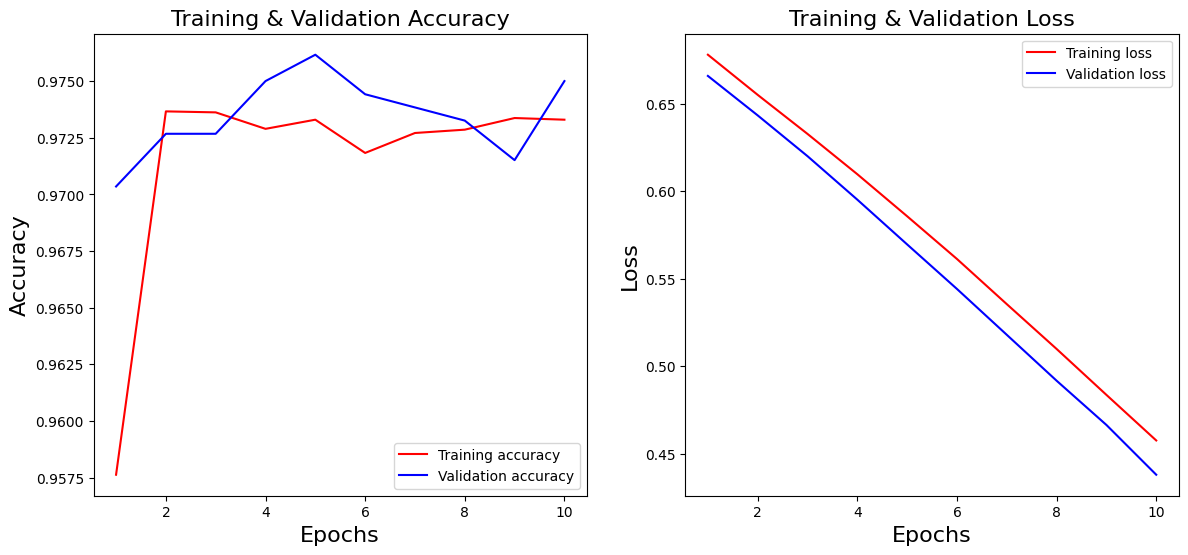

In [ ]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))


# Plot the model accuracy vs Epochs
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].plot(epochs, val_accuracy, 'b', label='Validation accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()


# Plot the loss vs Epochs
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].plot(epochs, val_loss_values, 'b', label='Validation loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend();

InceptionResNetV2

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from keras.preprocessing import image
pd.options.display.max_columns = 50
from sklearn.model_selection import KFold

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import accuracy_score, confusion_matrix,ConfusionMatrixDisplay

In [ ]:
#imported models for testing
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

In [ ]:
tf.__version__

'2.15.0'

In [ ]:
#image dimensions given to the model
img_width = 150
img_height = 150
img_channels = 3

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/RetinalImageClassification/Training_Set/RFMiD_Training_Labels.csv')
val_df = pd.read_csv('/content/drive/MyDrive/RetinalImageClassification/Evaluation_Set/RFMiD_Validation_Labels.csv')
test_df = pd.read_csv('/content/drive/MyDrive/RetinalImageClassification/Test_Set/RFMiD_Testing_Labels.csv')


In [ ]:
#This adds image path for each corresponding id, since the csv lists image number(id) and its relevant disease
train_df['img_path'] = [f'/content/drive/MyDrive/RetinalImageClassification/Training_Set/Training/{id}.png' for id in train_df['ID']]
val_df['img_path'] = [f'/content/drive/MyDrive/RetinalImageClassification/Evaluation_Set/Validation/{id}.png' for id in val_df['ID']]
test_df['img_path'] = [f'/content/drive/MyDrive/RetinalImageClassification/Test_Set/Test/{id}.png' for id in test_df['ID']]

In [ ]:
#excess data, dropped.
#Disease risk isn't helpful to the model, so it've been removed.
#ODPM and HR are not available in this dataset so they've been removed

train_df = train_df.drop(labels=['ID','ODPM', 'HR'], axis=1)
val_df = val_df.drop(labels=['ID', 'ODPM', 'HR'], axis=1)
test_df = test_df.drop(labels=['ID', 'ODPM', 'HR'], axis=1)

In [ ]:
Y_train = ['Disease_Risk']
Y_val = ['Disease_Risk']
Y_test = ['Disease_Risk']
# unq_disease = len(Y_train)

In [ ]:
#sets the preprocessing data of the images before passing it into the dataset
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                horizontal_flip=True,
                                                                vertical_flip=True,
                                                                rotation_range=90,
                                                                brightness_range=[0, 0.1],
                                                                preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

In [ ]:
test_gen = test_datagen.flow_from_dataframe(test_df,
                                            x_col='img_path',
                                            y_col=Y_test,
                                            target_size=(150,150),
                                            class_mode='raw',
                                            batch_size=8)

Found 390 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 250 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
def transfer_model_generator():
    pre_trained_model = InceptionResNetV2(
                                input_shape = (img_width,img_height, img_channels),
                                include_top = False,
                                weights = None)
    for layer in pre_trained_model.layers:
        layer.trainable = False
    last_layer = pre_trained_model.get_layer("mixed_7a")
    print('last layer output shape: ', last_layer.output_shape)
    last_output = last_layer.output
    #adding a binary classification layer
    x = layers.Flatten()(last_output)
    x = layers.Dense(1024, activation='relu')(x)
    #dense(1) creates a single neuron alongside sigmoid which is responsible for the binary classification
    x = layers.Dense (1, activation='sigmoid')(x)
    return Model(pre_trained_model.input, x)

In [ ]:
def custom_model_generator():
    return Sequential([
        Conv2D(64, (3,3), 1, activation='relu', input_shape=(img_width,img_height, img_channels)),
        MaxPooling2D(),
        Conv2D(32, (3,3), 1, activation='relu'),
        MaxPooling2D(),
        Conv2D(64, (3,3), 1, activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(256, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

In [ ]:
#parameter arrays for each model and its outputs
transfer_models = []
custom_models = []

transfer_histories = []
custom_histories = []

transfer_errors = []
custom_errors = []

transfer_accuracies = []
custom_accuracies = []

In [ ]:
#model fitting parameters
steps_per_epoch = 20
epochs = 10
validation_steps = 5

#folding parameters
n_splits = 3
k_folds = KFold(n_splits = n_splits)

#combine both training and validation dataframes
dataset = pd.concat([train_df, val_df], ignore_index=True)
#iterations
itr=0

In [ ]:
for train_dfk,val_dfk in k_folds.split(dataset):
    print(f'This is iteration number: {itr +1}')
    #prepare the dataset
    print("preparing the dataset")
    print("----------------------------------------------------------")
    train_genf = train_datagen.flow_from_dataframe(dataset.iloc[train_dfk],
                                              x_col='img_path',
                                              y_col=Y_train,
                                              target_size=(img_width,img_height),
                                              class_mode='raw',
                                              batch_size=32,
                                              shuffle=False)
    val_genf = test_datagen.flow_from_dataframe(dataset.iloc[val_dfk],
                                                x_col='img_path',
                                                y_col=Y_test,
                                                target_size=(img_width,img_height),
                                                class_mode='raw',
                                               batch_size=16)
    #generate new untrained models and add them to their respective arrays
    print("Generating the models")
    print("----------------------------------------------------------")
    transfer_models.append(transfer_model_generator())
    custom_models.append(custom_model_generator())
    #compile the model
    print("Compiling the models")
    print("----------------------------------------------------------")
    transfer_models[-1].compile(optimizer = RMSprop(learning_rate=0.00001),loss = 'binary_crossentropy', metrics = ['accuracy'])
    custom_models[-1].compile(optimizer = RMSprop(learning_rate=0.00001),loss = 'binary_crossentropy', metrics = ['accuracy'])
    #fit the model and save its history
    print("Fitting the models")
    print("----------------------------------------------------------")
    print("fitting the transfer model")
    transfer_histories.append(transfer_models[-1].fit(train_genf, validation_data = val_genf, steps_per_epoch=steps_per_epoch,epochs =epochs,validation_steps=validation_steps))
    print("fitting the custom model")
    custom_histories.append(custom_models[-1].fit(train_genf, validation_data = val_genf, steps_per_epoch=steps_per_epoch,epochs =epochs,validation_steps=validation_steps))
    #evaluate the model and get the accuracies
    print("Calculating the accuracy of each model")
    print("----------------------------------------------------------")
    print("Calculating the accuracy of the transfer model")
    error, acc = transfer_models[-1].evaluate(test_gen)
    transfer_errors.append(error)
    transfer_accuracies.append(acc)
    print("Calculating the accuracy of the custom model")
    #preventing out of bounds error by seperating the error and accuracy matricies.
    error, acc = custom_models[-1].evaluate(test_gen)
    custom_errors.append(error)
    custom_accuracies.append(acc)
    print(f'iteration number {itr +1} is done.')
    print("----------------------------------------------------------")
    print("----------------------------------------------------------")
    itr+=1

This is iteration number: 1
preparing the dataset
----------------------------------------------------------
Found 980 validated image filenames.
Found 56 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 726 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 798 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


Generating the models
----------------------------------------------------------
last layer output shape:  (None, 3, 3, 2080)
Compiling the models
----------------------------------------------------------
Fitting the models
----------------------------------------------------------
fitting the transfer model
Epoch 1/10
20/20 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.7834

20/20 [==============================] - 144s 6s/step - loss: 0.6924 - accuracy: 0.7834 - val_loss: 0.6911 - val_accuracy: 0.8750
Epoch 2/10
20/20 [==============================] - 104s 5s/step - loss: 0.6913 - accuracy: 0.8781
Epoch 3/10
20/20 [==============================] - 103s 5s/step - loss: 0.6905 - accuracy: 0.8609
Epoch 4/10
20/20 [==============================] - 107s 5s/step - loss: 0.6895 - accuracy: 0.8790
Epoch 5/10
20/20 [==============================] - 120s 6s/step - loss: 0.6889 - accuracy: 0.8535
Epoch 6/10
20/20 [==============================] - 109s 5s/step - loss: 0.6882 - accuracy: 0.8500
Epoch 7/10
20/20 [==============================] - 113s 6s/step - loss: 0.6870 - accuracy: 0.8742
Epoch 8/10
20/20 [==============================] - 110s 5s/step - loss: 0.6864 - accuracy: 0.8562
Epoch 9/10
20/20 [==============================] - 110s 5s/step - loss: 0.6855 - accuracy: 0.8594
Epoch 10/10
20/20 [==============================] - 116s 6s/step - loss: 0.68

20/20 [==============================] - 99s 5s/step - loss: 0.6922 - accuracy: 0.8408 - val_loss: 0.6901 - val_accuracy: 0.6786
Epoch 2/10
20/20 [==============================] - 87s 4s/step - loss: 0.6906 - accuracy: 0.8516
Epoch 3/10
20/20 [==============================] - 89s 4s/step - loss: 0.6884 - accuracy: 0.8678
Epoch 4/10
20/20 [==============================] - 89s 4s/step - loss: 0.6856 - accuracy: 0.8609
Epoch 5/10
20/20 [==============================] - 93s 4s/step - loss: 0.6805 - accuracy: 0.8953
Epoch 6/10
20/20 [==============================] - 88s 4s/step - loss: 0.6752 - accuracy: 0.8822
Epoch 7/10
20/20 [==============================] - 88s 4s/step - loss: 0.6715 - accuracy: 0.8328
Epoch 8/10
20/20 [==============================] - 86s 4s/step - loss: 0.6633 - accuracy: 0.8422
Epoch 9/10
20/20 [==============================] - 83s 4s/step - loss: 0.6542 - accuracy: 0.8406
Epoch 10/10
20/20 [==============================] - 89s 4s/step - loss: 0.6436 - accur

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1172 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 352 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


Generating the models
----------------------------------------------------------
last layer output shape:  (None, 3, 3, 2080)
Compiling the models
----------------------------------------------------------
Fitting the models
----------------------------------------------------------
fitting the transfer model
Epoch 1/10
17/20 [========================>.....] - ETA: 16s - loss: 0.6926 - accuracy: 0.7963

20/20 [==============================] - 134s 6s/step - loss: 0.6926 - accuracy: 0.7963 - val_loss: 0.6943 - val_accuracy: 0.4500
fitting the custom model
Epoch 1/10
17/20 [========================>.....] - ETA: 13s - loss: 0.6920 - accuracy: 0.8449

20/20 [==============================] - 92s 5s/step - loss: 0.6920 - accuracy: 0.8449 - val_loss: 0.6854 - val_accuracy: 0.7125
Calculating the accuracy of each model
----------------------------------------------------------
Calculating the accuracy of the transfer model
49/49 [==============================] - 79s 2s/step - loss: 0.6938 - accuracy: 0.4667
Calculating the accuracy of the custom model
49/49 [==============================] - 51s 1s/step - loss: 0.6857 - accuracy: 0.7359
iteration number 2 is done.
----------------------------------------------------------
----------------------------------------------------------
This is iteration number: 3
preparing the dataset
----------------------------------------------------------
Found 557 validated image filenames.
Found 479 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1150 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 374 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


Generating the models
----------------------------------------------------------
last layer output shape:  (None, 3, 3, 2080)
Compiling the models
----------------------------------------------------------
Fitting the models
----------------------------------------------------------
fitting the transfer model
Epoch 1/10
18/20 [==========================>...] - ETA: 9s - loss: 0.6923 - accuracy: 0.8671 

20/20 [==============================] - 128s 6s/step - loss: 0.6923 - accuracy: 0.8671 - val_loss: 0.6902 - val_accuracy: 0.8875
fitting the custom model
Epoch 1/10
18/20 [==========================>...] - ETA: 7s - loss: 0.6925 - accuracy: 0.7702 

20/20 [==============================] - 87s 4s/step - loss: 0.6925 - accuracy: 0.7702 - val_loss: 0.6754 - val_accuracy: 0.8000
Calculating the accuracy of each model
----------------------------------------------------------
Calculating the accuracy of the transfer model
49/49 [==============================] - 73s 1s/step - loss: 0.6910 - accuracy: 0.8513
Calculating the accuracy of the custom model
49/49 [==============================] - 53s 1s/step - loss: 0.6735 - accuracy: 0.8667
iteration number 3 is done.
----------------------------------------------------------
----------------------------------------------------------


In [ ]:
#selecting the transfer model with the highest accuracy
selected_transfer_index = np.argmax(transfer_accuracies)

print(f'The best model was found at fold = {selected_transfer_index}')

selected_transfer_model = transfer_models[selected_transfer_index]

selected_transfer_history = transfer_histories[selected_transfer_index]

selected_transfer_accuracy = transfer_accuracies[selected_transfer_index]

selected_transfer_predictions = selected_transfer_model.predict(test_gen, verbose=1)

The best model was found at fold = 0
49/49 [==============================] - 81s 2s/step


In [ ]:
#selecting the custom model with the highest accuracy
selected_custom_index = np.argmax(custom_accuracies)

print(f'The best model was found at fold = {selected_custom_index}')

selected_custom_model = custom_models[selected_custom_index]

selected_custom_history = custom_histories[selected_custom_index]

selected_custom_accuracy = custom_accuracies[selected_custom_index]

selected_custom_predictions = selected_custom_model.predict(test_gen, verbose=1)

The best model was found at fold = 0
49/49 [==============================] - 52s 1s/step


In [ ]:
#sequentially iterates through the array to find if eye is diseased or not.
diseased_labels = []
for i in test_gen.labels:
    if(i.any() == 1):
        diseased_labels.append(1)
    else:
        diseased_labels.append(0)

In [ ]:
# uses the average to create a threshold for custom model
transfer_thres = np.average(selected_transfer_predictions)
transfer_y_pred = (selected_transfer_predictions > transfer_thres)*1
print("custom model threshold: ",transfer_thres)

custom model threshold:  0.51003045


The transfer model confusion matrix


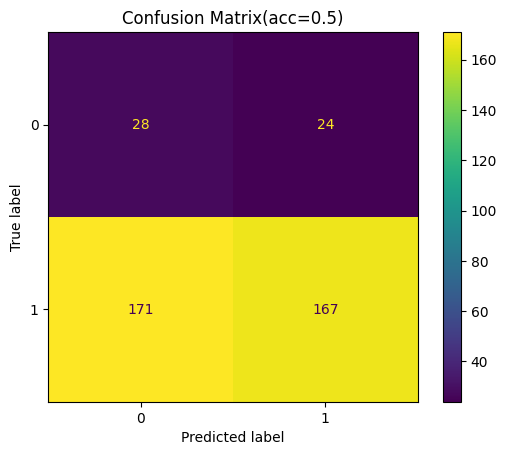

In [ ]:
print("The transfer model confusion matrix")
transfer_acc = accuracy_score(diseased_labels, transfer_y_pred)
transfer_cm = confusion_matrix(diseased_labels, transfer_y_pred)
transfer_disp = ConfusionMatrixDisplay(transfer_cm)
transfer_disp.plot()
plt.title(f'Confusion Matrix(acc={transfer_acc})')
plt.show()

In [ ]:
# uses the average to create a threshold for custom model
custom_thres = np.average(selected_custom_predictions)
custom_y_pred = (selected_custom_predictions > custom_thres)*1
print("custom model threshold: ",custom_thres)

custom model threshold:  0.6606871


The custom model confusion matrix


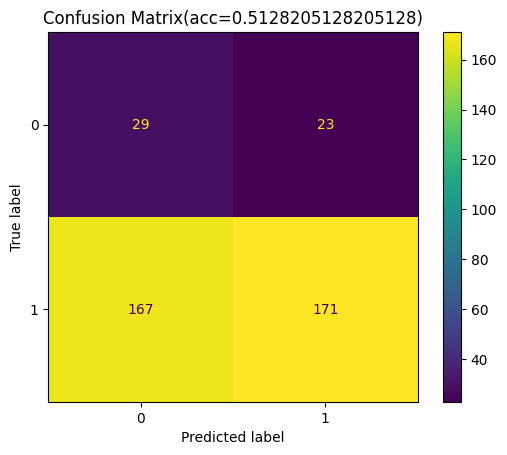

In [ ]:
print("The custom model confusion matrix")
transfer_acc = accuracy_score(diseased_labels, custom_y_pred)
transfer_cm = confusion_matrix(diseased_labels, custom_y_pred)
transfer_disp = ConfusionMatrixDisplay(transfer_cm)
transfer_disp.plot()
plt.title(f'Confusion Matrix(acc={transfer_acc})')
plt.show()

The transfer model graphical representation of the accuracy


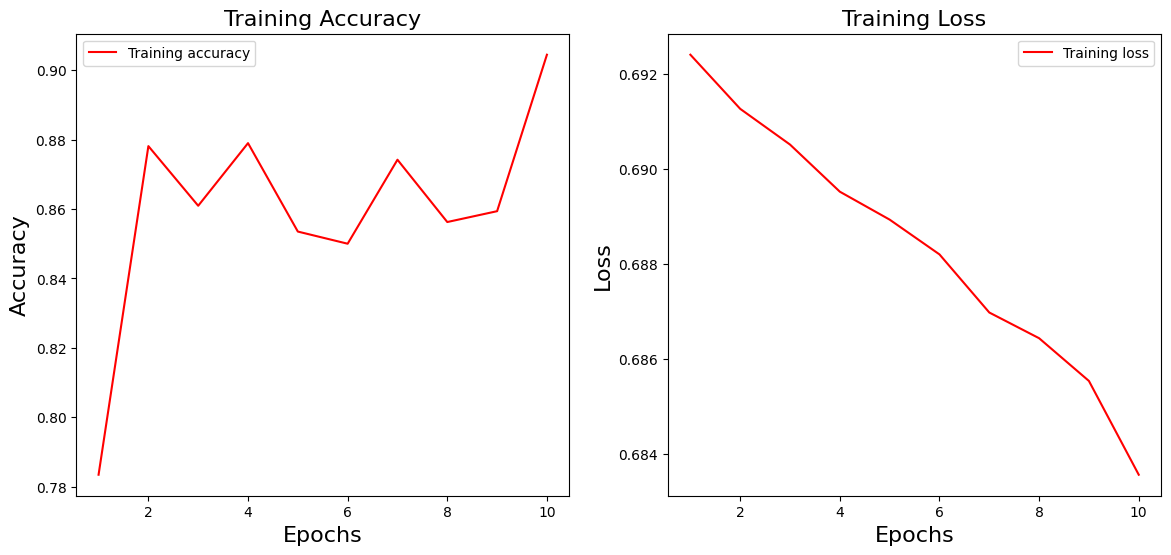

In [ ]:
print("The transfer model graphical representation of the accuracy")
history_dict = selected_transfer_history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].set_title('Training Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].set_title('Training Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

The custom model graphical representation of the accuracy


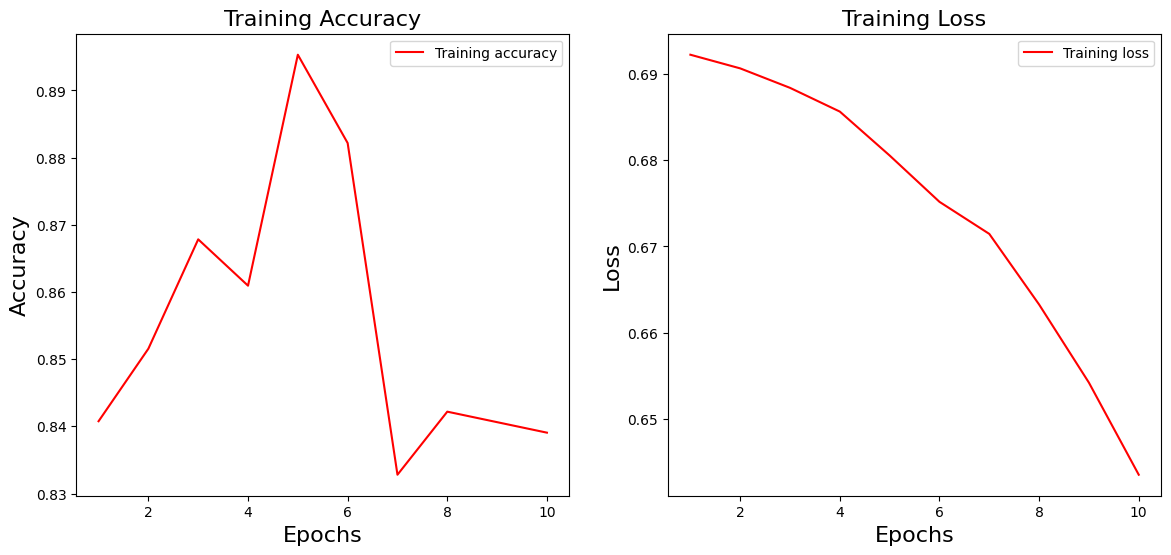

In [ ]:
print("The custom model graphical representation of the accuracy")
history_dict = selected_custom_history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

epochs = range(1, len(loss_values) + 1)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
#
# Plot the model accuracy vs Epochs
#
ax[0].plot(epochs, accuracy, 'r', label='Training accuracy')
ax[0].set_title('Training Accuracy', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=16)
ax[0].set_ylabel('Accuracy', fontsize=16)
ax[0].legend()
#
# Plot the loss vs Epochs
#
ax[1].plot(epochs, loss_values, 'r', label='Training loss')
ax[1].set_title('Training Loss', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=16)
ax[1].set_ylabel('Loss', fontsize=16)
ax[1].legend()

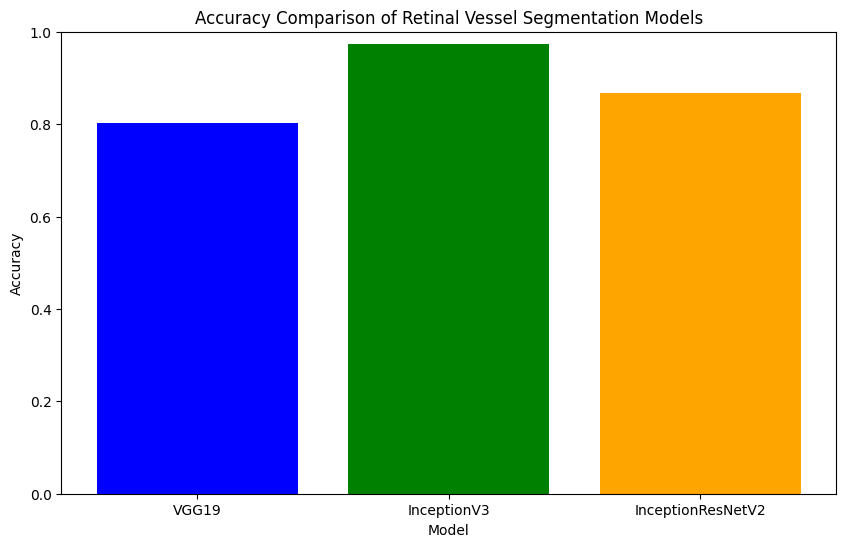

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ['VGG19', 'InceptionV3', 'InceptionResNetV2']

# Evaluation accuracies
accuracies = [0.8017, 0.9727, 0.8667]

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.title('Accuracy Comparison of Retinal Vessel Segmentation Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Limit y-axis from 0 to 1 for accuracy
plt.show()


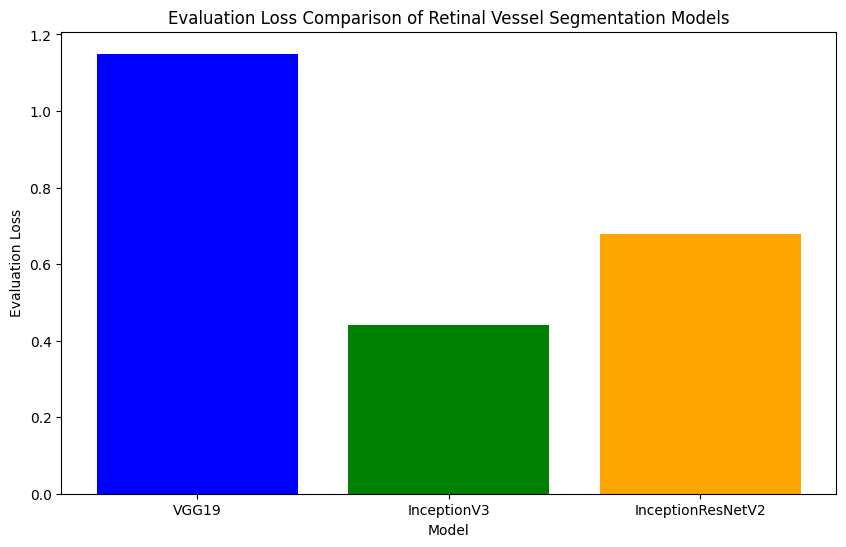

In [ ]:
import matplotlib.pyplot as plt

# Model names
models = ['VGG19', 'InceptionV3', 'InceptionResNetV2']

# Evaluation losses
losses = [1.1495, 0.4395, 0.6783]

# Plotting loss
plt.figure(figsize=(10, 6))
plt.bar(models, losses, color=['blue', 'green', 'orange'])
plt.title('Evaluation Loss Comparison of Retinal Vessel Segmentation Models')
plt.xlabel('Model')
plt.ylabel('Evaluation Loss')
plt.show()


AlexNet

In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import glob as gb

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import os

# Load the training CSV file containing image IDs and disease risk categories
csv_path_train = '/content/drive/MyDrive/RetinalImageClassification/Training_Set/RFMiD_Training_Labels.csv'
df_train = pd.read_csv(csv_path_train)

# Define the base directory for training images
base_dir_train = '/content/drive/MyDrive/RetinalImageClassification/Training_Set/Training'
image_paths_train = [os.path.join(base_dir_train, f"{img_id}.png") for img_id in df_train['ID'] if os.path.exists(os.path.join(base_dir_train, f"{img_id}.png"))]

# Load training images and labels
train_data = []
train_labels = df_train['Disease_Risk'].values

for image_path_train in image_paths_train:
    image_train = tf.keras.preprocessing.image.load_img(image_path_train, target_size=(227, 227))
    image_train = tf.keras.preprocessing.image.img_to_array(image_train)
    image_train = tf.keras.applications.imagenet_utils.preprocess_input(image_train, mode='tf')
    train_data.append(image_train)

train_data = np.array(train_data)
train_labels = np.array(train_labels)


In [4]:
# Define the AlexNet architecture
inputs = Input(shape=(227, 227, 3))
x = Conv2D(96, (11, 11), strides=(4, 4), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
x = Conv2D(256, (5, 5), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
x = Conv2D(384, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(384, (3, 3), padding='same', activation='relu')(x)
x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)
x = Flatten()(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)  # Assuming binary classification (healthy vs. diseased)

# Create the AlexNet model
train_model = Model(inputs=inputs, outputs=outputs)

In [5]:
from tensorflow.keras.optimizers import Adam
# Compile the training model
train_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with print statements for each epoch
for epoch in range(10):
    print(f"Epoch {epoch + 1}/10")
    print("Training...")
    train_history = train_model.fit(train_data, train_labels, epochs=1, batch_size=32, validation_split=0.2, verbose=1)
    print(f"Training Accuracy: {train_history.history['accuracy'][-1]}")
    print(f"Validation Accuracy: {train_history.history['val_accuracy'][-1]}")
    print()

Epoch 1/10
Training...
14/14 [==============================] - 127s 9s/step - loss: 1.0768 - accuracy: 0.8404 - val_loss: 0.4584 - val_accuracy: 0.8571
Training Accuracy: 0.8404494524002075
Validation Accuracy: 0.8571428656578064

Epoch 2/10
Training...
14/14 [==============================] - 85s 6s/step - loss: 0.4370 - accuracy: 0.8562 - val_loss: 0.4131 - val_accuracy: 0.8571
Training Accuracy: 0.8561797738075256
Validation Accuracy: 0.8571428656578064

Epoch 3/10
Training...
14/14 [==============================] - 90s 7s/step - loss: 0.4405 - accuracy: 0.8562 - val_loss: 0.4287 - val_accuracy: 0.8571
Training Accuracy: 0.8561797738075256
Validation Accuracy: 0.8571428656578064

Epoch 4/10
Training...
14/14 [==============================] - 86s 6s/step - loss: 0.4262 - accuracy: 0.8562 - val_loss: 0.4135 - val_accuracy: 0.8571
Training Accuracy: 0.8561797738075256
Validation Accuracy: 0.8571428656578064

Epoch 5/10
Training...
14/14 [==============================] - 85s 6s/step

In [6]:
import pandas as pd
import numpy as np
# Load the evaluation CSV file containing image IDs and disease risk categories
csv_path_eval = '/content/drive/MyDrive/RetinalImageClassification/Evaluation_Set/RFMiD_Validation_Labels.csv'
df_eval = pd.read_csv(csv_path_eval)

# Define the base directory for evaluation images
base_dir_eval = '/content/drive/MyDrive/RetinalImageClassification/Evaluation_Set/Validation'
image_paths_eval = [os.path.join(base_dir_eval, f"{img_id}.png") for img_id in df_eval['ID'] if os.path.exists(os.path.join(base_dir_eval, f"{img_id}.png"))]

# Load evaluation images and labels
eval_data = []
eval_labels = df_eval['Disease_Risk'].values

for image_path_eval in image_paths_eval:
    image_eval = tf.keras.preprocessing.image.load_img(image_path_eval, target_size=(227, 227))
    image_eval = tf.keras.preprocessing.image.img_to_array(image_eval)
    image_eval = tf.keras.applications.vgg19.preprocess_input(image_eval)
    eval_data.append(image_eval)


In [7]:
eval_data = np.array(eval_data)
eval_labels = np.array(eval_labels)
eval_data = eval_data.astype('float32')
eval_labels = eval_labels.astype('float32')
eval_data = eval_data[:min(len(eval_data), len(eval_labels))]
eval_labels = eval_labels[:min(len(eval_data), len(eval_labels))]

# Evaluate the model on the evaluation data
eval_loss, eval_accuracy = train_model.evaluate(eval_data, eval_labels, verbose=0)
print(f"Evaluation Loss: {eval_loss}")
print(f"Evaluation Accuracy: {eval_accuracy}")

Evaluation Loss: 4.287182807922363
Evaluation Accuracy: 0.8434237837791443


In [8]:
import numpy as np
from sklearn.metrics import classification_report
predictions = train_model.predict(eval_data)
predictions = np.round(predictions)
report = classification_report(eval_labels, predictions)
print(report)


15/15 [==============================] - 21s 1s/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        75
         1.0       0.84      1.00      0.92       404

    accuracy                           0.84       479
   macro avg       0.42      0.50      0.46       479
weighted avg       0.71      0.84      0.77       479



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
confusion_matrix = confusion_matrix(eval_labels, predictions)

# Print the confusion matrix
print(confusion_matrix)


[[  0  75]
 [  0 404]]


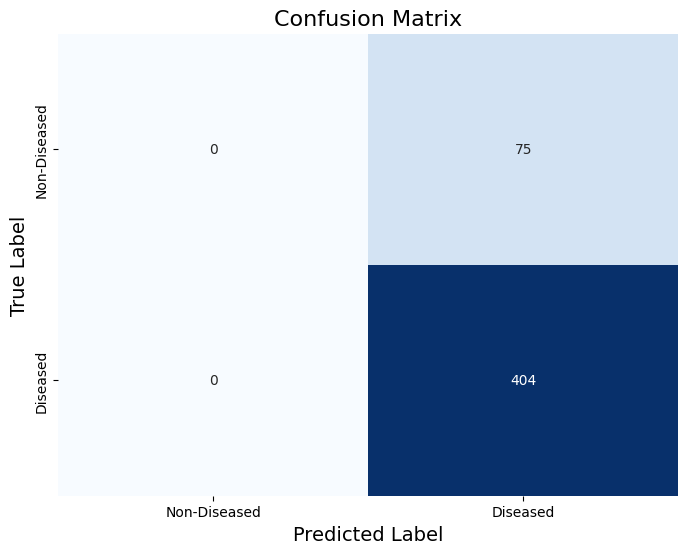

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = ['Non-Diseased', 'Diseased']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()


In [9]:
df_train = pd.read_csv('/content/drive/MyDrive/RetinalImageClassification/Training_Set/RFMiD_Training_Labels.csv')

#ID and Disease_Risk are not labels to be trained. So drop them from the dataframe.
df_train = df_train.drop(['ID', 'Disease_Risk'], axis=1)

In [12]:
def check_disease(df):
    disease_name, zeroCount, oneCount = [], [], []
    rowLen = len(df)
    for (column_name, column) in df.items():
        disease_name.append(column_name)
        zeroCount.append(df[column_name].value_counts()[0])
    oneCount = [rowLen - x for x in zeroCount]

    return disease_name, zeroCount, oneCount

# Insert the image ID
def img_id(df,num):
    id_list = []
    for i in range(num):
        id_list.append(i+1)
    df.insert(0,'ID',id_list)

In [13]:
disease_name, zeroCount, oneCount = check_disease(df_train)

In [14]:
for i in range(45):
    if oneCount[i] <= 120:
        df_train = df_train.drop([disease_name[i]], axis=1)

In [15]:
disease_name, zeroCount, oneCount = check_disease(df_train)

In [16]:
# Insert Image ID
img_id(df_train,len(df_train))

1/1 [==============================] - 0s 84ms/step


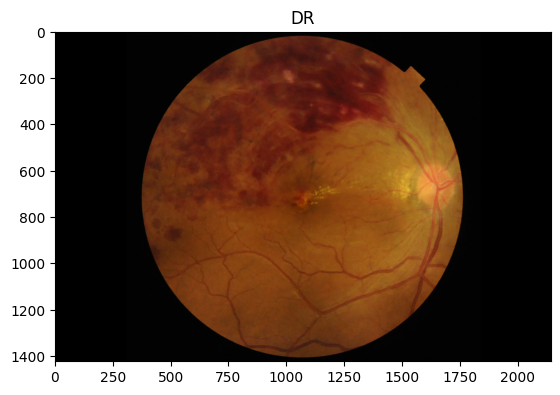

In [21]:
#Validate on an image
from keras.preprocessing import image
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# model = keras.models.load_model('driver_drowsiness_detection_model_old_dataset.h5')
# model = keras.models.load_model('eye_close_classifier.h5')

# img_width=256
# img_height=256

new_path = '/content/drive/MyDrive/RetinalImageClassification/Test_Set/Test/134.png'
image_result=Image.open(new_path)


def data_resizing_process(dirs):
    datas = image.load_img(dirs, target_size = (227, 227))
    res = image.img_to_array(datas)
    res = np.expand_dims(res, axis = 0)
    res /= 255
    return res

# img = image.load_img(new_path, target_size=(img_width,img_height,3))
# img = image.img_to_array(img)
# img = np.expand_dims(img, axis=0)
# img = img/255.

img = data_resizing_process(new_path)
result = train_model.predict(img)
# print(np.argmax(result))

Categories=disease_name
image_result=plt.imshow(image_result)
plt.title(Categories[np.argmax(result)])
plt.show()

MobileNetV2

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import glob as gb

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

In [ ]:
# Load the training CSV file containing image IDs and disease risk categories
csv_path_train = '/content/drive/MyDrive/RetinalImageClassification/Training_Set/RFMiD_Training_Labels.csv'
df_train = pd.read_csv(csv_path_train)

# Define the base directory for training images
base_dir_train = '/content/drive/MyDrive/RetinalImageClassification/Training_Set/Training'
image_paths_train = [os.path.join(base_dir_train, f"{img_id}.png") for img_id in df_train['ID'] if os.path.exists(os.path.join(base_dir_train, f"{img_id}.png"))]

# Load training images and labels
train_data = []
train_labels = df_train['Disease_Risk'].values

for image_path_train in image_paths_train:
    image_train = tf.keras.preprocessing.image.load_img(image_path_train, target_size=(224, 224))
    image_train = tf.keras.preprocessing.image.img_to_array(image_train)
    image_train = tf.keras.applications.imagenet_utils.preprocess_input(image_train, mode='tf')
    train_data.append(image_train)

train_data = np.array(train_data)
train_labels = np.array(train_labels)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

# Define the MobileNetV2 architecture
inputs = Input(shape=(224, 224, 3))
base_model = MobileNetV2(weights='imagenet', include_top=False, input_tensor=inputs)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  # Reduced the number of neurons for a lighter model
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)  # Assuming binary classification (healthy vs. diseased)

# Create the MobileNetV2 model
train_model = Model(inputs=base_model.input, outputs=outputs)


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam
# Compile the training model
train_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with print statements for each epoch
for epoch in range(10):
    print(f"Epoch {epoch + 1}/10")
    print("Training...")
    train_history = train_model.fit(train_data, train_labels, epochs=1, batch_size=32, validation_split=0.2, verbose=1)
    print(f"Training Accuracy: {train_history.history['accuracy'][-1]}")
    print(f"Validation Accuracy: {train_history.history['val_accuracy'][-1]}")
    print()

Epoch 1/10
Training...
14/14 [==============================] - 60s 4s/step - loss: 21.4354 - accuracy: 0.7393 - val_loss: 17.2861 - val_accuracy: 0.8571
Training Accuracy: 0.7393258213996887
Validation Accuracy: 0.8571428656578064

Epoch 2/10
Training...
14/14 [==============================] - 54s 4s/step - loss: 7.6762 - accuracy: 0.8022 - val_loss: 7.6758 - val_accuracy: 0.8571
Training Accuracy: 0.802247166633606
Validation Accuracy: 0.8571428656578064

Epoch 3/10
Training...
14/14 [==============================] - 51s 4s/step - loss: 2.2395 - accuracy: 0.8090 - val_loss: 3.7293 - val_accuracy: 0.8393
Training Accuracy: 0.8089887499809265
Validation Accuracy: 0.8392857313156128

Epoch 4/10
Training...
14/14 [==============================] - 61s 4s/step - loss: 1.1927 - accuracy: 0.8697 - val_loss: 4.4349 - val_accuracy: 0.8571
Training Accuracy: 0.8696629405021667
Validation Accuracy: 0.8571428656578064

Epoch 5/10
Training...
14/14 [==============================] - 51s 4s/step

In [ ]:
import pandas as pd
import numpy as np
# Load the evaluation CSV file containing image IDs and disease risk categories
csv_path_eval = '/content/drive/MyDrive/RetinalImageClassification/Evaluation_Set/RFMiD_Validation_Labels.csv'
df_eval = pd.read_csv(csv_path_eval)

# Define the base directory for evaluation images
base_dir_eval = '/content/drive/MyDrive/RetinalImageClassification/Evaluation_Set/Validation'
image_paths_eval = [os.path.join(base_dir_eval, f"{img_id}.png") for img_id in df_eval['ID'] if os.path.exists(os.path.join(base_dir_eval, f"{img_id}.png"))]

# Load evaluation images and labels
eval_data = []
eval_labels = df_eval['Disease_Risk'].values

for image_path_eval in image_paths_eval:
    image_eval = tf.keras.preprocessing.image.load_img(image_path_eval, target_size=(224, 224))
    image_eval = tf.keras.preprocessing.image.img_to_array(image_eval)
    image_eval = tf.keras.applications.vgg19.preprocess_input(image_eval)
    eval_data.append(image_eval)


In [ ]:
eval_data = np.array(eval_data)
eval_labels = np.array(eval_labels)
eval_data = eval_data.astype('float32')
eval_labels = eval_labels.astype('float32')
eval_data = eval_data[:min(len(eval_data), len(eval_labels))]
eval_labels = eval_labels[:min(len(eval_data), len(eval_labels))]

# Evaluate the model on the evaluation data
eval_loss, eval_accuracy = train_model.evaluate(eval_data, eval_labels, verbose=0)
print(f"Evaluation Loss: {eval_loss}")
print(f"Evaluation Accuracy: {eval_accuracy}")

Evaluation Loss: 2.4902353286743164
Evaluation Accuracy: 0.8434237837791443


In [ ]:
import numpy as np
from sklearn.metrics import classification_report
predictions = train_model.predict(eval_data)
predictions = np.round(predictions)
report = classification_report(eval_labels, predictions)
print(report)


15/15 [==============================] - 25s 2s/step
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        75
         1.0       0.84      1.00      0.92       404

    accuracy                           0.84       479
   macro avg       0.42      0.50      0.46       479
weighted avg       0.71      0.84      0.77       479



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
confusion_matrix = confusion_matrix(eval_labels, predictions)

# Print the confusion matrix
print(confusion_matrix)


[[  0  75]
 [  0 404]]


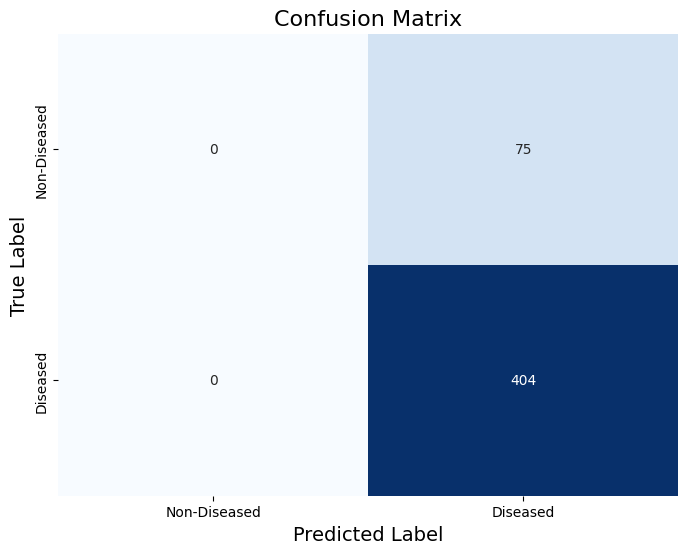

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = ['Non-Diseased', 'Diseased']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()


EfficientNetB0

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
import glob as gb

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

In [ ]:
# Load the training CSV file containing image IDs and disease risk categories
csv_path_train = '/content/drive/MyDrive/RetinalImageClassification/Training_Set/RFMiD_Training_Labels.csv'
df_train = pd.read_csv(csv_path_train)

# Define the base directory for training images
base_dir_train = '/content/drive/MyDrive/RetinalImageClassification/Training_Set/Training'
image_paths_train = [os.path.join(base_dir_train, f"{img_id}.png") for img_id in df_train['ID'] if os.path.exists(os.path.join(base_dir_train, f"{img_id}.png"))]

# Load training images and labels
train_data = []
train_labels = df_train['Disease_Risk'].values

for image_path_train in image_paths_train:
    image_train = tf.keras.preprocessing.image.load_img(image_path_train, target_size=(224, 224))
    image_train = tf.keras.preprocessing.image.img_to_array(image_train)
    image_train = tf.keras.applications.imagenet_utils.preprocess_input(image_train, mode='tf')
    train_data.append(image_train)

train_data = np.array(train_data)
train_labels = np.array(train_labels)


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model

# Define the EfficientNetB0 architecture
inputs = Input(shape=(224, 224, 3))
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_tensor=inputs)

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers for classification
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)  # Reduced the number of neurons for a lighter model
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)  # Assuming binary classification (healthy vs. diseased)

# Create the EfficientNetB0 model
train_model = Model(inputs=base_model.input, outputs=outputs)


16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
from tensorflow.keras.optimizers import Adam
# Compile the training model
train_model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with print statements for each epoch
for epoch in range(10):
    print(f"Epoch {epoch + 1}/10")
    print("Training...")
    train_history = train_model.fit(train_data, train_labels, epochs=1, batch_size=32, validation_split=0.2, verbose=1)
    print(f"Training Accuracy: {train_history.history['accuracy'][-1]}")
    print(f"Validation Accuracy: {train_history.history['val_accuracy'][-1]}")
    print()

Epoch 1/10
Training...
14/14 [==============================] - 88s 6s/step - loss: 14.1889 - accuracy: 0.7438 - val_loss: 3.1788 - val_accuracy: 0.8571
Training Accuracy: 0.7438202500343323
Validation Accuracy: 0.8571428656578064

Epoch 2/10
Training...
14/14 [==============================] - 74s 5s/step - loss: 1.7925 - accuracy: 0.7775 - val_loss: 0.8858 - val_accuracy: 0.8571
Training Accuracy: 0.7775281071662903
Validation Accuracy: 0.8571428656578064

Epoch 3/10
Training...
14/14 [==============================] - 83s 6s/step - loss: 0.9250 - accuracy: 0.7596 - val_loss: 0.4201 - val_accuracy: 0.8571
Training Accuracy: 0.7595505714416504
Validation Accuracy: 0.8571428656578064

Epoch 4/10
Training...
14/14 [==============================] - 80s 6s/step - loss: 0.5204 - accuracy: 0.8180 - val_loss: 0.4173 - val_accuracy: 0.8571
Training Accuracy: 0.8179775476455688
Validation Accuracy: 0.8571428656578064

Epoch 5/10
Training...
14/14 [==============================] - 79s 6s/step

In [ ]:
import pandas as pd
import numpy as np
# Load the evaluation CSV file containing image IDs and disease risk categories
csv_path_eval = '/content/drive/MyDrive/RetinalImageClassification/Evaluation_Set/RFMiD_Validation_Labels.csv'
df_eval = pd.read_csv(csv_path_eval)

# Define the base directory for evaluation images
base_dir_eval = '/content/drive/MyDrive/RetinalImageClassification/Evaluation_Set/Validation'
image_paths_eval = [os.path.join(base_dir_eval, f"{img_id}.png") for img_id in df_eval['ID'] if os.path.exists(os.path.join(base_dir_eval, f"{img_id}.png"))]

# Load evaluation images and labels
eval_data = []
eval_labels = df_eval['Disease_Risk'].values

for image_path_eval in image_paths_eval:
    image_eval = tf.keras.preprocessing.image.load_img(image_path_eval, target_size=(224, 224))
    image_eval = tf.keras.preprocessing.image.img_to_array(image_eval)
    image_eval = tf.keras.applications.vgg19.preprocess_input(image_eval)
    eval_data.append(image_eval)


In [ ]:
eval_data = np.array(eval_data)
eval_labels = np.array(eval_labels)
eval_data = eval_data.astype('float32')
eval_labels = eval_labels.astype('float32')
eval_data = eval_data[:min(len(eval_data), len(eval_labels))]
eval_labels = eval_labels[:min(len(eval_data), len(eval_labels))]

# Evaluate the model on the evaluation data
eval_loss, eval_accuracy = train_model.evaluate(eval_data, eval_labels, verbose=0)
print(f"Evaluation Loss: {eval_loss}")
print(f"Evaluation Accuracy: {eval_accuracy}")

Evaluation Loss: 1.6912145614624023
Evaluation Accuracy: 0.7954071164131165


In [ ]:
import numpy as np
from sklearn.metrics import classification_report
predictions = train_model.predict(eval_data)
predictions = np.round(predictions)
report = classification_report(eval_labels, predictions)
print(report)


15/15 [==============================] - 47s 3s/step
              precision    recall  f1-score   support

         0.0       0.26      0.16      0.20        75
         1.0       0.85      0.91      0.88       404

    accuracy                           0.80       479
   macro avg       0.55      0.54      0.54       479
weighted avg       0.76      0.80      0.78       479



In [ ]:
from sklearn.metrics import confusion_matrix
# Calculate the confusion matrix
confusion_matrix = confusion_matrix(eval_labels, predictions)

# Print the confusion matrix
print(confusion_matrix)


[[ 12  63]
 [ 35 369]]


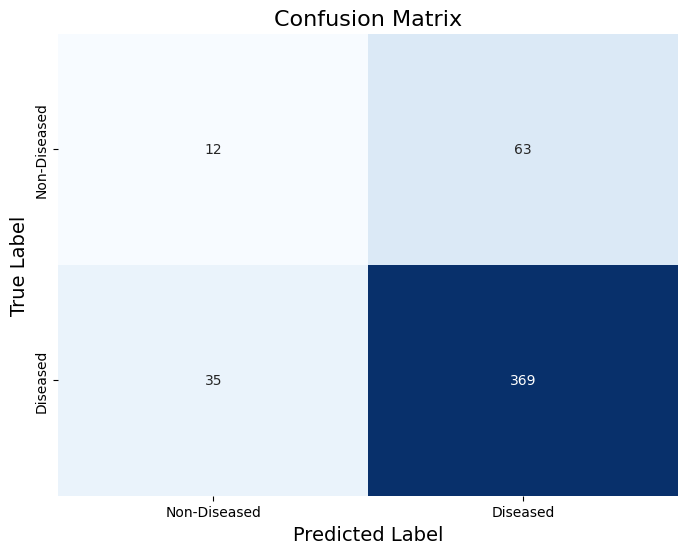

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = ['Non-Diseased', 'Diseased']
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.show()


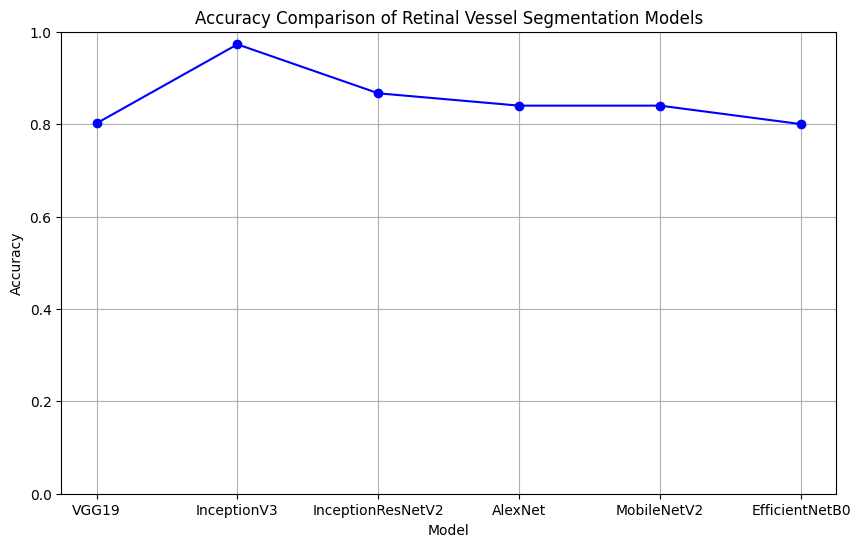

In [ ]:
import matplotlib.pyplot as plt

# Model names and accuracies
models = ['VGG19', 'InceptionV3', 'InceptionResNetV2', 'AlexNet', 'MobileNetV2', 'EfficientNetB0']
accuracies = [0.8017, 0.9727, 0.8667, 0.84, 0.84, 0.80]

# Plotting accuracy as line chart
plt.figure(figsize=(10, 6))
plt.plot(models, accuracies, marker='o', color='blue', linestyle='-')
plt.title('Accuracy Comparison of Retinal Vessel Segmentation Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # Limit y-axis from 0 to 1 for accuracy
plt.grid(True)  # Add gridlines for better visualization
plt.show()


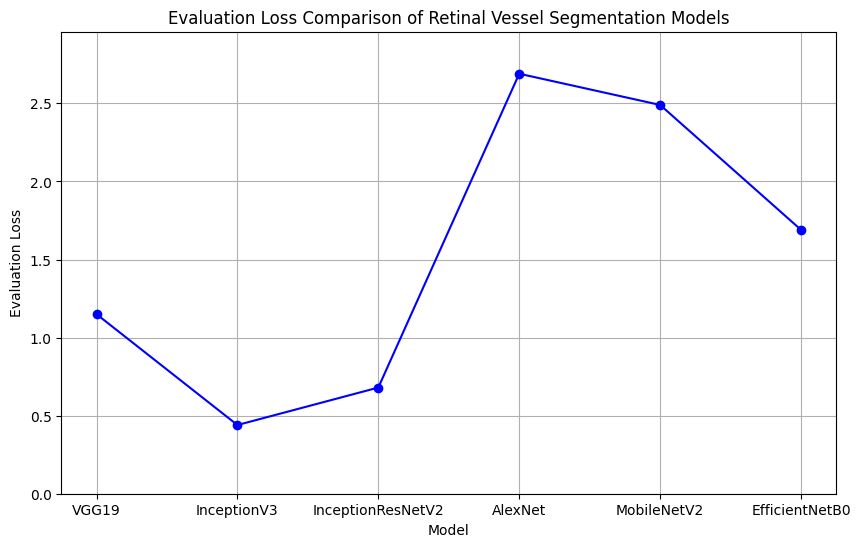

In [ ]:
import matplotlib.pyplot as plt

# Model names and losses
models = ['VGG19', 'InceptionV3', 'InceptionResNetV2', 'AlexNet', 'MobileNetV2', 'EfficientNetB0']
losses = [1.15, 0.44, 0.68, 2.69, 2.49, 1.69]  # Rounded-off values

# Plotting loss
plt.figure(figsize=(10, 6))
plt.plot(models, losses, marker='o', color='blue', linestyle='-')
plt.title('Evaluation Loss Comparison of Retinal Vessel Segmentation Models')
plt.xlabel('Model')
plt.ylabel('Evaluation Loss')
plt.ylim(0, max(losses) * 1.1)  # Set y-axis limit slightly above the maximum loss value
plt.grid(True)  # Add gridlines for better visualization
plt.show()
